# Point-by-point refined map visualisation notebook  
__Written by Haixing Fang, Jon Wright and James Ball__  
__Date: 21/02/2025__

This notebook will convert the (potentially) multi-valued results of a point-by-point strain refinement process to a single-valued 'TensorMap' with many useful export formats, like H5, Paraview XDMF, and MTEX CTF.

In [1]:
import os

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'

In [2]:
exec(open('/data/id11/nanoscope/install_ImageD11_from_git.py').read())

Change : 
1. the dataset name (*dset_path*)
2. the phase name (*phase_str*)

In [3]:
# this cell is tagged with 'parameters'
# to view the tag, select the cell, then find the settings gear icon (right or left sidebar) and look for Cell Tags

# python environment stuff
PYTHONPATH = setup_ImageD11_from_git( os.path.join( os.environ['HOME'],'Code', 'Tutorial', 'SCRIPTS'), 'ImageD11' )# ( os.path.join( os.environ['HOME'],'Code'), 'ImageD11_git' )

# dataset file to import
dset_path = '../FeAu_0p5_tR_nscope/FeAu_0p5_tR_nscope_top_200um/FeAu_0p5_tR_nscope_top_200um_dataset.h5'

# which phase to index
phase_str = 'Fe'

# the minimum number of peaks you want a pixel to have to be counted
min_unique = 50

# Setting path via: 
sys.path.insert(0, /home/esrf/ljegou/Code/Tutorial/SCRIPTS/ImageD11 )


# Running from: /home/esrf/ljegou/Code/Tutorial/SCRIPTS/ImageD11/ImageD11/__init__.py


In [4]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize

from ImageD11.grain import grain
from ImageD11 import unitcell
import ImageD11.sinograms.dataset
from ImageD11.sinograms.point_by_point import PBPMap, PBPRefine
from ImageD11.sinograms.tensor_map import TensorMap
from ImageD11.nbGui import nb_utils as utils

# %matplotlib ipympl

# Load data
1. The dataset
2. The phases

## Dataset

In [5]:
ds = ImageD11.sinograms.dataset.load(dset_path)
print(ds)

dataroot = "/data/id11/inhouse2/test_data_3DXRD/S3DXRD/FeAu/RAW_DATA"
analysisroot = "/data/id11/inhouse2/test_data_3DXRD/S3DXRD/FeAu/PROCESSED_DATA/20250626_LJ"
sample = "FeAu_0p5_tR_nscope"
dset = "top_200um"
shape = ( 275, 1448)
# scans 275 from 1.1 to 275.1


## Phases
If the parameter file was a json, we can access the unit cells via `ds.phases.unitcells`

In [6]:
ds.phases = ds.get_phases_from_disk()
ds.phases.unitcells

{'Au': Au | [ 4.005  4.005  4.005 90.    90.    90.   ] | 225,
 'Fe': Fe | [ 2.8694  2.8694  2.8694 90.     90.     90.    ] | 229,
 'B2': B2 | [ 3.8867  3.8867  3.8867 90.     90.     90.    ] | 221,
 'CeO2': CeO2 | [ 5.41143  5.41143  5.41143 90.      90.      90.     ] | F}

In [7]:
ref_ucell = ds.phases.unitcells[phase_str]
print(ref_ucell)

Fe | [ 2.8694  2.8694  2.8694 90.     90.     90.    ] | 229


# Point-by-point refined map
Loading the refined map

In [8]:
!cp -r ../FeAu_0p5_tR_nscope/FeAu_0p5_tR_nscope_top_200um/FeAu_0p5_tR_nscope_top_200um_dataset.h5 FeAu_0p5_tR_nscope/FeAu_0p5_tR_nscope_top_200um/

Loading peaks


Loading input map
Loading output map


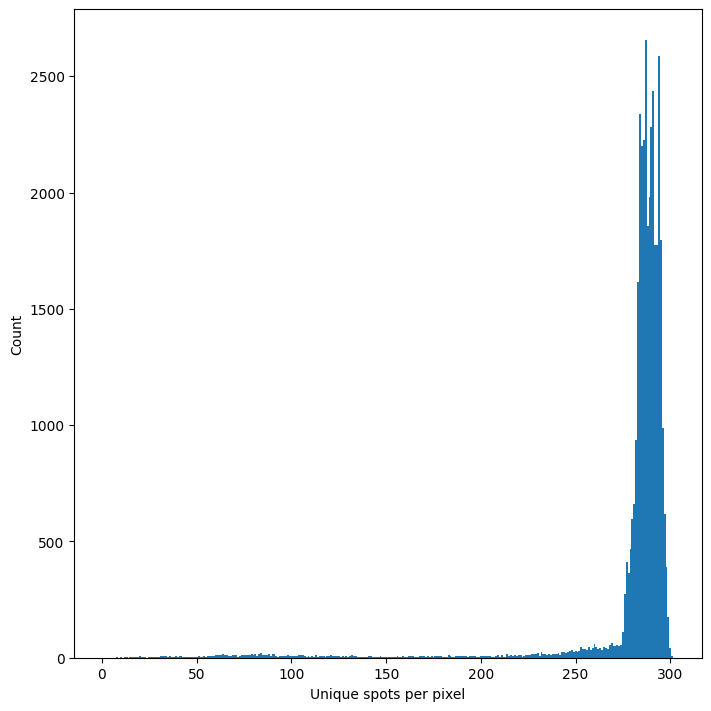

In [9]:
refmanpath = os.path.splitext(ds.refmanfile)[0] + f'_{phase_str}.h5'
refine = PBPRefine.from_h5(refmanpath)
refine.refinedmap.plot_nuniq_hist()

Choose the minimum number of peaks you want a pixel to have to be counted : `min_unique`

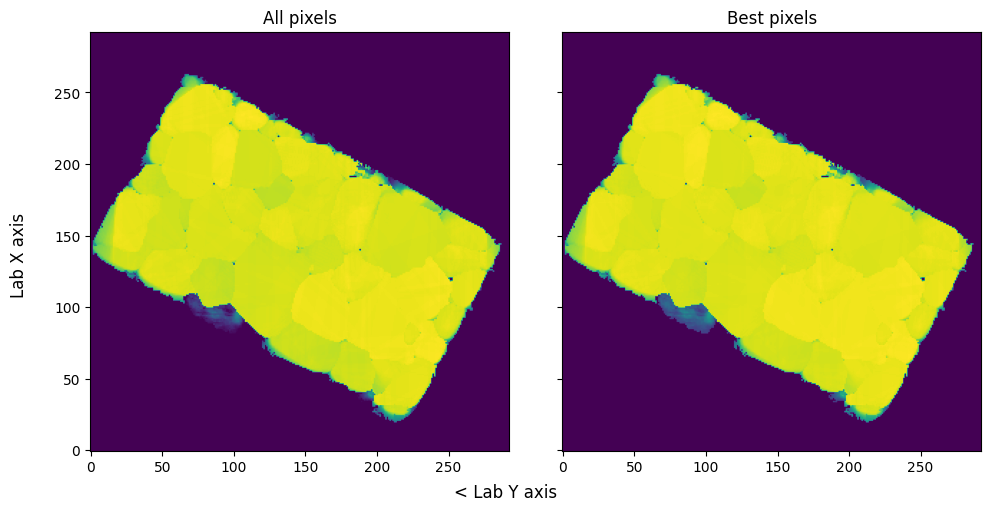

In [10]:
refine.refinedmap.choose_best(min_unique)
refine.refinedmap.plot_best(min_unique)

# Make TensorMap

Now make a TensorMap from the refined map so we can plot and export
## ID map
First let's make a phase id map from our pbpmap

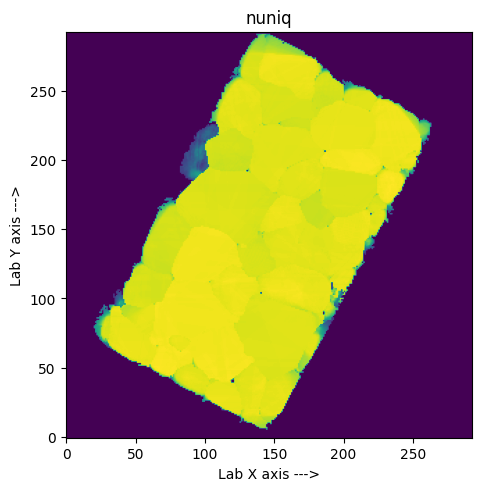

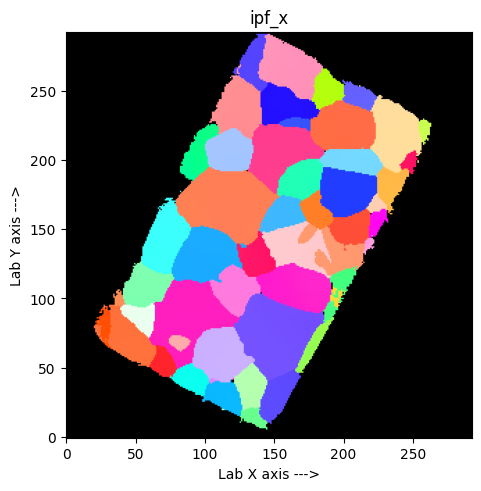

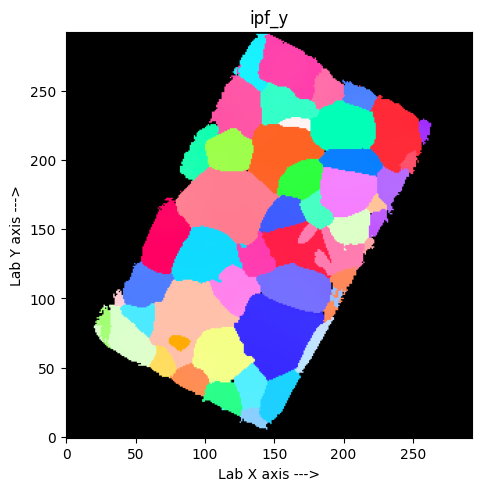

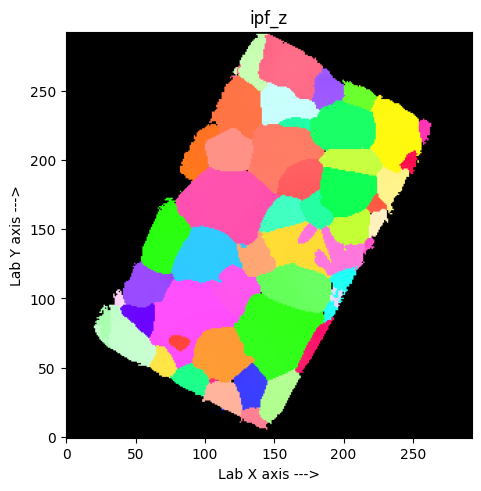

In [11]:
phase_ids = TensorMap.recon_order_to_map_order(np.where(refine.refinedmap.best_nuniq > min_unique, 0, -1))
eps_sample = TensorMap.recon_order_to_map_order(refine.refinedmap.best_eps)
tmap = TensorMap.from_pbpmap(refine.refinedmap, steps=(1, ds.ystep, ds.ystep), phases={0: ref_ucell})
tmap['phase_ids'] = phase_ids
tmap['eps_sample'] = eps_sample
tmap.get_ipf_maps()
tmap.plot('nuniq')
tmap.plot('ipf_x')
tmap.plot('ipf_y')
tmap.plot('ipf_z')
eul = tmap.euler  # trigger calculation of all the maps

## Strains
Plot the strains inside the major phase grains

/tmp/ipykernel_469789/3744789049.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('RdBu_r')


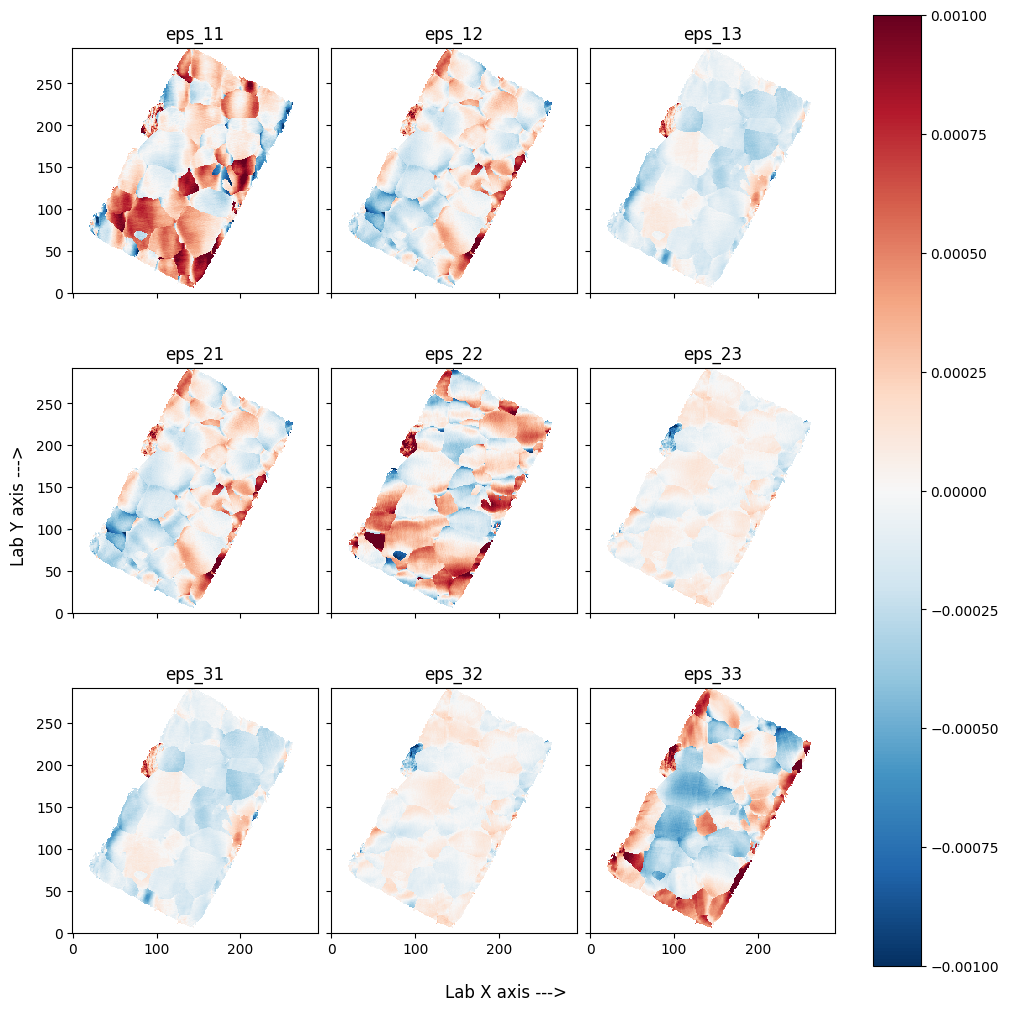

In [12]:
fig, axs = plt.subplots(3,3, sharex=True, sharey=True, layout='constrained', figsize=(10,10))
cmap = cm.get_cmap('RdBu_r')
normalizer = Normalize(-1e-3, 1e-3)
im = cm.ScalarMappable(norm=normalizer, cmap=cmap)
for i in range(3):
    for j in range(3):
        axs[i,j].imshow(tmap.eps_sample[0, ..., i, j], origin="lower", cmap=cmap, norm=normalizer, interpolation='nearest')
        axs[i,j].set_title(f'eps_{i+1}{j+1}')
fig.supxlabel('Lab X axis --->')
fig.supylabel('Lab Y axis --->')
fig.colorbar(im, ax=axs.ravel().tolist())
plt.show()

You can check what is the mean unitcell

In [13]:
mean_a = np.nanmean(tmap.unitcell[0,:,:,0])
mean_b = np.nanmean(tmap.unitcell[0,:,:,1])
mean_c = np.nanmean(tmap.unitcell[0,:,:,2])

print('Mean unit cells : a = {:.4f}, b = {:.4f}, c = {:.4f}'.format(mean_a,mean_b,mean_c))

Mean unit cells : a = 2.8695, b = 2.8700, c = 2.8698


You can check what is the mean stress in the sample. If you expect no stress, this is the moment where you need to adjust the cell parameters.

In [14]:
mean_e11 = np.nanmean(tmap.eps_sample[0,:,:,0,0])
mean_e22 = np.nanmean(tmap.eps_sample[0,:,:,1,1])
mean_e33 = np.nanmean(tmap.eps_sample[0,:,:,2,2])

print('Mean stress : e11 = {:.4e}, e22 = {:.4e}, e33 = {:.4e}'.format(mean_e11,mean_e22,mean_e33))

Mean stress : e11 = 1.8531e-04, e22 = 1.3598e-04, e33 = 7.2368e-06


## Ajust the cell parameters to get 0 stress

This is function to compute the volume of the cell define by its lattice parameters

In [15]:
def cellvolume(latticepar):
    """
    calculate unit cell volume [angstrom^3]
    """
    a = latticepar[0]
    b = latticepar[1]
    c = latticepar[2]
    calp = np.cos(np.deg2rad(latticepar[3]))
    cbet = np.cos(np.deg2rad(latticepar[4]))
    cgam = np.cos(np.deg2rad(latticepar[5]))
    
    angular = np.sqrt(1 - calp**2 - cbet**2 - cgam**2 + 2*calp*cbet*cgam)
    
    Vcell = a*b*c*angular
    
    return Vcell

We compute and plot the average volume of all the pixels from this phase, and the c/a ratio (this is mainly for hexagonal phases)

In [16]:
Vcells = []
ca_ratios = []
for i in range(tmap.unitcell.shape[1]):
    for j in range(tmap.unitcell.shape[2]):
        if not np.isnan(tmap.unitcell[0,i,j,:]).any():
            Vcell =  cellvolume( tmap.unitcell[0, i, j, :] )
            ca_ratios.append( tmap.unitcell[0,i,j,2] / np.mean(tmap.unitcell[0,i,j,0:2]) )
            Vcells.append(Vcell)

We plot the the average volume.

1.0000208956368486 1.0000190989706923
23.631515925854973 23.633460187342713


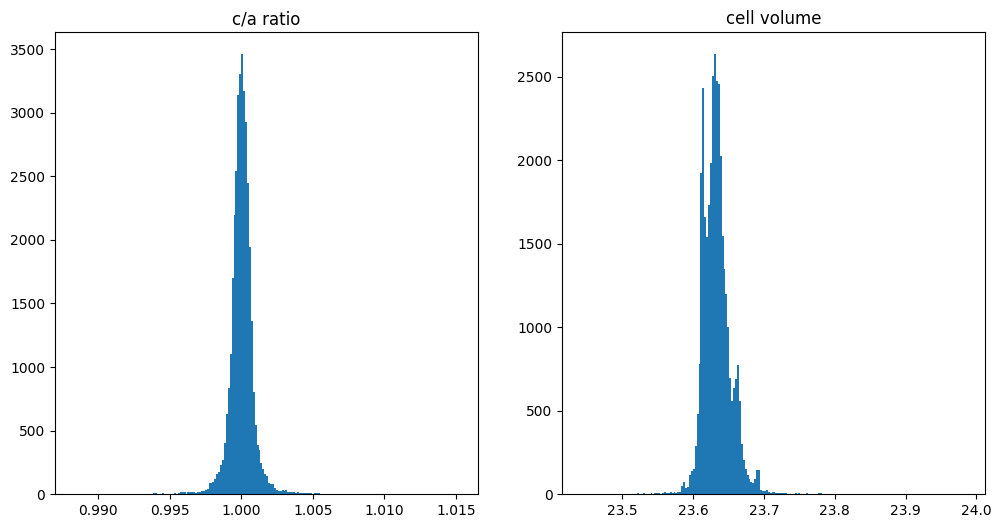

In [17]:
f, a = plt.subplots(1, 2, figsize=(12, 6))
a[0].hist(ca_ratios, bins=200);
a[1].hist(Vcells, bins=200);
a[0].set(title='c/a ratio');
a[1].set(title='cell volume');
print(np.median(ca_ratios), np.mean(ca_ratios))
print(np.median(Vcells), np.mean(Vcells))

We can play with `new_cell` value to test different Volume cell until the difference between `V0` and `Vcells` are close. 
Then update the parameter file with this `new_cell` value and re run all the notebooks.

In [18]:
new_cell = 2.8697
V0 = cellvolume([new_cell, new_cell, new_cell, 90, 90, 90] )
print(V0 - np.median(Vcells), V0 - np.mean(Vcells))

0.0009746390180254139 -0.0009696224697144373


if we have a previous tomographic TensorMap, we can try to get the labels map too:

In [19]:
try:
    tmap_tomo =  TensorMap.from_h5(ds.grainsfile, h5group='TensorMap_' + phase_str)
    tmap.add_map('labels', tmap_tomo.labels)
except (FileNotFoundError, OSError, KeyError):
    # couldn't find one, continue anyway
    pass

# Export
## TensorMap

save the refined TensorMap to disk.
If you already ran and saved the results of the refinement notebook for this specific phase (`phase_str`), you have to delete the existing file *XXX_refined_tmap_{phase_str}*

In [20]:
# refined_tmap_path = os.path.join(ds.analysispath, f'{ds.sample}_{ds.dset}_refined_tmap_{phase_str}.h5')
# tmap.to_h5(refined_tmap_path)
# tmap.to_paraview(refined_tmap_path)

# MTEX

you can also do an MTEX export if you like:

In [21]:
# refined_ctf_path = os.path.join(ds.analysispath, f'{ds.sample}_{ds.dset}_refined_tmap_{phase_str}.ctf')
# tmap.to_ctf_mtex(refined_ctf_path, z_index=0)

In [22]:
ds.save()